In [61]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Buisiness Understanding

Q1. Which groups of people are most responsive to each type of offer?  
Q2. How to present each type of offer?

### Data Understanding

**Portfolio**: Offers sent during 30-day test period (10 offers x 6 fields)
- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

ex)
0 row의 경우, 10 달러의 리워드가 있으며 채널은 email, mobile, social을 통해 고객에게 전달됨.   
리워드를 받기 위해선 10 달러를 써야 하며, 사용 가능 기간은 7일임.  
프로모션의 형태는 bogo(하나사면 하나 더 줌)이며 해당 프로모션의 id는 ae264어쩌구저쩌구임.

**Profile**: Rewards program users (17000 users x 5 fields)
- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.shape

(17000, 5)

ex) 0 row의 경우, 성별은 None임(그놈의 PC충들). 나이는 missing. 고객 id는 위와 같음.  
2017년2월12일에 고객이 되었으며, 수익은 없는듯함.

**Transcript**: Event log (306648 events x 4 fields)
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
- offer id: (string/hash) not associated with any "transaction"
- amount: (numeric) money spent in "transaction"
- reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
transcript.shape

(306534, 4)

ex) 0 row의 경우, 고객 id는 78afa어쩌구저쩌구이며(profile 셋에 있음), 오퍼를 받은 것이 확인됨.  
오퍼의 종류는 9b98b어쩌구저쩌구이고(portfolio 셋에 있음), 테스트 시작하자마자 오퍼를 받음.

### Data Preparing

#### 1. Transcript 데이터 프레임의 Value Column 내 dict 형태 값들을 활용해, 데이터 프레임 확장: Key는 새로운 칼럼, Value는 칼럼 내의 value

In [8]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [9]:
df = pd.DataFrame(transcript['value'].tolist())

In [10]:
df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


**offer id, offer_id 컬럼이 생성. 각각 칼럼의 내 id가 존재하는 경우, 서로 다른 칼럼에는 id가 존재하지 않음. 그냥 타이핑 오류인 듯. 한쪽에 몰아야 함.**

In [11]:
offer_ids = df[~df['offer_id'].isnull()]['offer_id']

In [12]:
df.loc[offer_ids.index, 'offer id'] = df.loc[offer_ids.index, 'offer_id']

In [13]:
df.drop('offer_id', axis=1, inplace=True)
df.head()

,offer id,amount,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [14]:
transcript = pd.concat([transcript.drop(['value'], axis=1), df], axis=1)
transcript.head()

,person,event,time,offer id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


#### 2. portfolio 데이터 프레임의 channels 칼럼 내 리스트 형태의 value들도 칼럼 변환 후 더미코드화

In [17]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [18]:
def extract_channels():
    for i, channel_lst in portfolio['channels'].items():
        for channel in channel_lst:
            if channel == 'email':
                portfolio.loc[i, 'email'] = 1
            elif channel == 'mobile':
                portfolio.loc[i, 'mobile'] = 1
            elif channel == 'social':
                portfolio.loc[i, 'social'] = 1
            elif channel == 'web':
                portfolio.loc[i, 'web'] = 1
    portfolio.drop('channels', axis=1, inplace=True)

extract_channels()

In [19]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,NaN
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,NaN,1.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,NaN,1.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,NaN,NaN,1.0


**3. 칼럼 이름 조정 후, 일단 싹 다 join으로 붙여보자**

In [20]:
transcript.rename(columns={'person': 'user_id', 'offer id': 'offer_id'}, inplace=True)
portfolio.rename(columns={'id': 'offer_id', 'reward': 'possible_reward'}, inplace=True)
profile.rename(columns={'id': 'user_id'}, inplace=True)

In [21]:
transcript.head()

,user_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [22]:
portfolio.head()

,possible_reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,NaN
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,NaN,1.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,NaN,1.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,NaN,NaN,1.0


In [23]:
profile.head()

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [27]:
df = pd.merge(pd.merge(transcript, portfolio, how='left', on='offer_id'), profile, how='left', on='user_id')
df.head()

,user_id,event,time,offer_id,amount,reward,possible_reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,5.0,7.0,bogo,1.0,1.0,NaN,1.0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,20.0,10.0,discount,1.0,NaN,NaN,1.0,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,10.0,7.0,discount,1.0,1.0,NaN,1.0,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,None,118,20171002,NaN


**Data merged!**

In [52]:
offer_received = df[df['event']=='offer received']['user_id'].tolist()

In [53]:
offer_viewed = df[df['event']=='offer viewed']['user_id'].tolist()

In [54]:
transaction = df[df['event']=='transaction']['user_id'].tolist()

In [55]:
offer_completed = df[df['event']=='offer completed']['user_id'].tolist()

In [56]:
i = 0
for offer in offer_completed:
    if offer in offer_received:
        i = i + 1
print(i)

33579


In [57]:
i = 0
for offer in offer_completed:
    if offer in offer_viewed:
        i = i + 1
print(i)

33466


In [58]:
i = 0
for offer in offer_completed:
    if offer in transaction:
        i = i + 1
print(i)

33579


In [45]:
len(offer_received)

76277

In [59]:
len(offer_viewed)

57725

In [60]:
len(transaction)

138953

In [46]:
len(offer_completed)

33579

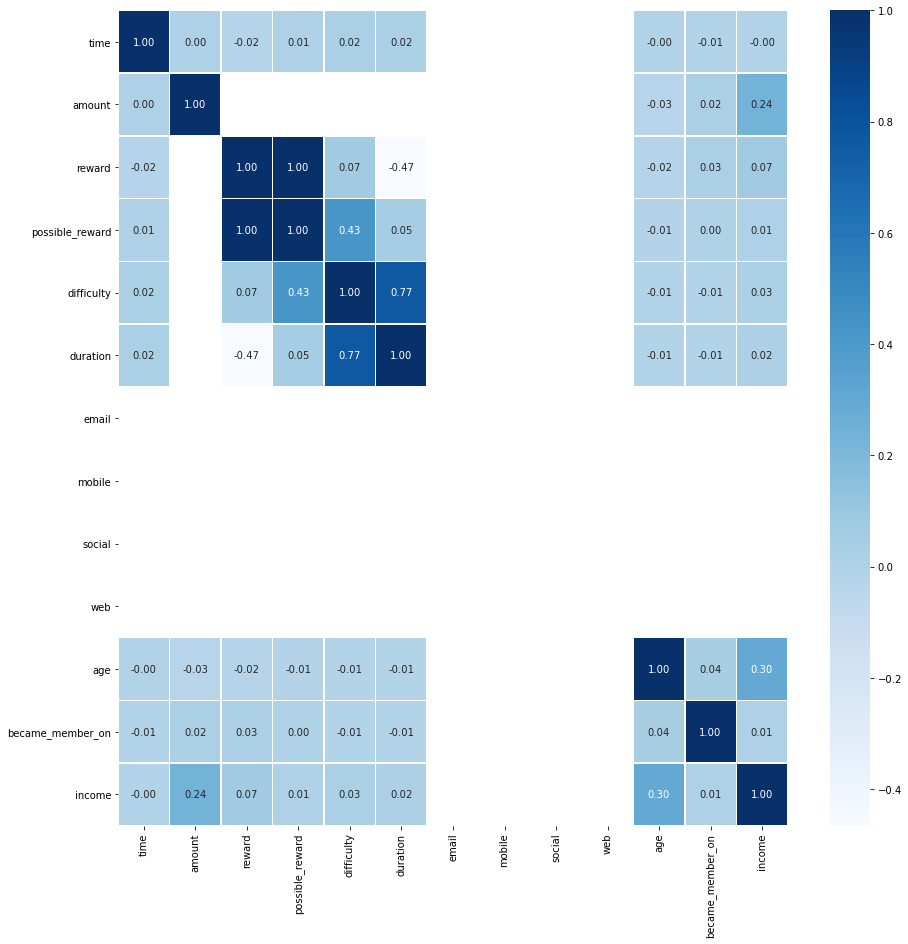

In [62]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=df.corr(), annot=True,
            fmt= '.2f', linewidths=.5, cmap='Blues')

offer를 쓴 사람과 쓰지 않은 사람을 나눈 뒤, 각각의 변수에 대한 data distribution을 확인해보자